In [1]:
import os
if "datasets.ipynb" in os.listdir():
    os.chdir("../")
print("Running in {}".format(os.getcwd()))

Running in /data/hpcdata/users/anddon76/icenet/icenet-experimental


# Test Run an Image-to-Image Pipeline with HF Diffusers

## 1. Configure Image-to-Image Pipeline
Following the below HuggingFace tutorial:
- [Image-to-image](https://huggingface.co/docs/diffusers/using-diffusers/img2img)

In [2]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

# set up pipeline
pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()

2024-01-26 03:13:35.707006: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-26 03:13:35.747734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-26 03:13:35.747768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-26 03:13:35.748807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-26 03:13:35.756218: I tensorflow/core/platform/cpu_feature_guar

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# set up dataset
from utils import IceNetDataSetPyTorch
dataset_config = "dataset_config.single_month.json"
train_ds = IceNetDataSetPyTorch(dataset_config, "train", batch_size=2, shuffling=True)
val_ds = IceNetDataSetPyTorch(dataset_config, "val", batch_size=2, shuffling=False)
test_ds = IceNetDataSetPyTorch(dataset_config, "test", batch_size=2, shuffling=False)

In [4]:
train_ds[0][0].shape, train_ds[0][1].shape

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(torch.Size([9, 432, 432]), torch.Size([1, 432, 432]))

In [5]:
# modify autoencoder to have proper number of i/o channels
pipeline.vae.encoder.conv_in, pipeline.vae.decoder.conv_out

(Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

In [4]:
from torch import nn
in_channels = 9
mid_channels = 128
out_channels = 1
pipeline.vae.encoder.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels,
                                         kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
pipeline.vae.decoder.conv_out = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels,
                                          kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
pipeline.vae.encoder.conv_in, pipeline.vae.decoder.conv_out

(Conv2d(9, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)))

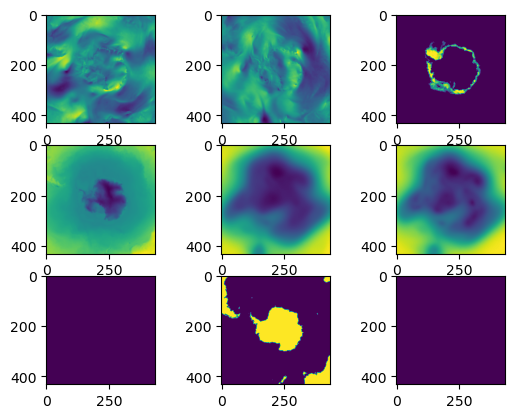

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        ax[i][j].imshow(train_ds[0][0][3*i + j, :, :])
plt.show()

In [17]:
# test entire pipeline
with torch.autocast(device_type="cuda"):
    init_image = train_ds[0][0]
    output = pipeline("", image=init_image)
    image = output.images[0]

/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/diffusers/image_processor.py:546: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

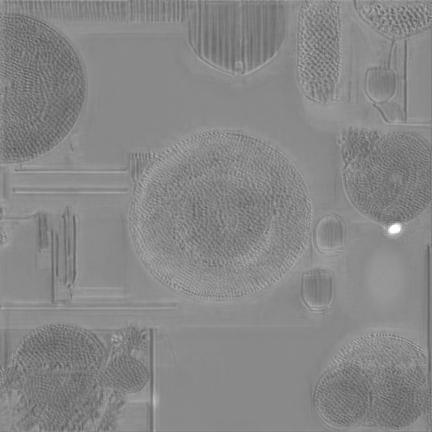

In [18]:
image

In [19]:
import numpy as np
np.array(image).shape

(432, 432)

## 2. Deconstruct Pipeline for Better Understanding
Following the below HuggingFace tutorial:
- [Understanding pipelines, models and schedulers](https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline)

It's helpful to have an overview of the StableDiffusion pipeline architecture we consider as we walk through the section below. Note that we ignore the text encoder and prompt in our case and pass in zeros of shape `(batch_size, sequence_length=1, embedding_dim=768)` for the text embeddings. In the future, however, one could finetune the text embedding component of this architecture to prompt different forecast styles, e.g., "high ice" or "low ice" or "high ice in beaufort sea and low ice in barents sea" forecasts.

![](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png)

### 2.1 Conditioning noised image → Encoded latent noised image

In [37]:
# conditioning noised image -> encoded latent noised image
with torch.autocast(device_type="cuda"):
    z = pipeline.vae.encode(init_image.to(torch.half).to("cuda").unsqueeze(0))
z

AutoencoderKLOutput(latent_dist=<diffusers.models.autoencoders.vae.DiagonalGaussianDistribution object at 0x7f534cea66d0>)

In [24]:
# original noised image > encoded latent noised image
encoded_image = z.latent_dist.mode()
encoded_image.shape

torch.Size([1, 4, 54, 54])

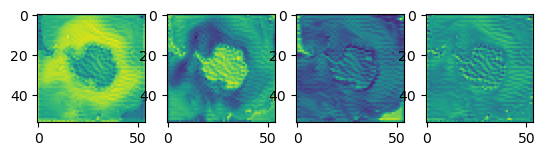

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
mat = encoded_image.detach().cpu().numpy()
for i in range(4):
    ax[i].imshow(mat[0, i, :, :])
plt.show()

### 2.2 Encoded latent noised image → Encoded latent denoised image

In [30]:
# encoded latent noised image -> encoded latent denoised image
with torch.autocast(device_type="cuda"):
    encoded_output = pipeline.unet(encoded_image, timestep=40, encoder_hidden_states=torch.zeros((1, 1, 768)))
encoded_output

UNet2DConditionOutput(sample=tensor([[[[-1.2051e+00, -6.7461e+00, -4.2461e+00,  ..., -8.7256e-01,
           -2.5254e+00, -2.9863e+00],
          [-1.5625e+00, -2.8926e+00, -1.6934e+00,  ..., -2.7461e+00,
           -9.2812e+00, -2.1797e+00],
          [-2.8066e+00, -3.0918e+00, -8.1787e-01,  ..., -1.1221e+00,
           -8.4375e-01, -1.3398e+00],
          ...,
          [ 1.2817e-01, -1.8584e+00, -2.1680e+00,  ..., -3.5000e+00,
           -4.4297e+00, -2.6309e+00],
          [ 9.2627e-01, -2.2424e-01, -2.8125e-01,  ..., -2.3438e+00,
           -4.8320e+00, -1.0234e+00],
          [ 7.0801e-02,  1.6562e+00,  1.0706e-01,  ..., -1.4814e+00,
           -1.5566e+00, -4.2334e-01]],

         [[ 1.2219e-01,  1.6787e+00,  1.2344e+00,  ...,  1.1589e-02,
            1.7295e+00,  1.0439e+00],
          [ 3.2051e+00,  2.3242e+00,  8.4521e-01,  ..., -5.8301e-01,
            1.1826e+00,  2.7871e+00],
          [ 1.8237e-01,  1.3145e+00, -7.6514e-01,  ...,  3.0762e+00,
            1.4678e+00,  8.52

In [31]:
encoded_output.sample.shape

torch.Size([1, 4, 54, 54])

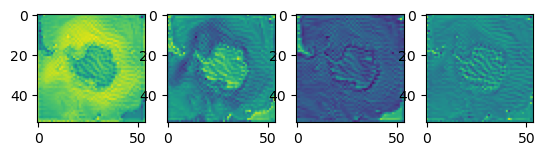

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4)
mat = encoded_output.sample.detach().cpu().numpy()
for i in range(4):
    ax[i].imshow(mat[0, i, :, :])
plt.show()

### 2.3 Encoded latent denoised image → Denoised image (forecast)

In [34]:
# encoded latent denoised image -> denoised image
with torch.autocast(device_type="cuda"):
    output = pipeline.vae.decoder(encoded_output.sample)
output

tensor([[[[-0.0441, -0.0416, -0.0305,  ..., -0.0438, -0.0964,  0.0358],
          [-0.1290, -0.0843,  0.0213,  ...,  0.0024, -0.0319,  0.0676],
          [-0.1888, -0.0629, -0.0632,  ...,  0.0573,  0.0130,  0.1052],
          ...,
          [-0.1647,  0.0243,  0.0949,  ..., -0.0795,  0.0062,  0.0958],
          [-0.0922,  0.1221,  0.0030,  ...,  0.0056,  0.0368,  0.0383],
          [-0.0757,  0.0206,  0.0043,  ..., -0.0963,  0.0410, -0.0019]]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ConvolutionBackward0>)

In [35]:
output.shape

torch.Size([1, 1, 432, 432])

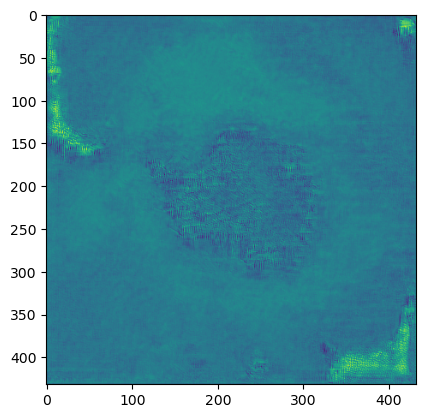

In [36]:
mat = output.detach().cpu().numpy()
plt.imshow(mat[0, 0, :, :])

### 2.4 Walk through Autoencoder

In [11]:
with torch.autocast(device_type="cuda"):
    out = pipeline.vae(init_image.unsqueeze(0))
out

DecoderOutput(sample=tensor([[[[ 0.1385,  0.2457,  0.3145,  ...,  0.2268,  0.2090,  0.1970],
          [ 0.3127,  0.1992,  0.2598,  ...,  0.0812,  0.0500,  0.1758],
          [ 0.0899,  0.1062,  0.2212,  ..., -0.1820, -0.1042,  0.1805],
          ...,
          [ 0.0566,  0.1479,  0.0870,  ...,  0.2457,  0.0768,  0.1785],
          [-0.0379,  0.0127, -0.0043,  ...,  0.0031, -0.0643,  0.2290],
          [ 0.0134,  0.0135,  0.0457,  ...,  0.0047,  0.0961,  0.0408]]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ConvolutionBackward0>))

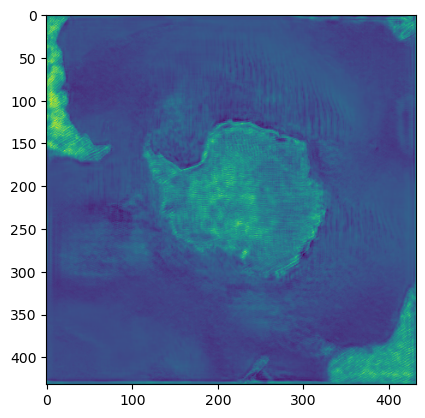

In [16]:
out_mat = out.sample.squeeze().detach().cpu()
plt.imshow(out_mat)

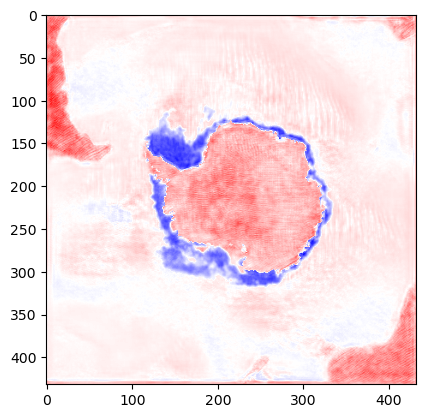

In [22]:
target_mat = train_ds[0][1].squeeze().detach().cpu()
plt.imshow((out_mat-target_mat), cmap="bwr")

In [24]:
((out_mat - target_mat)**2).sum()

tensor(20891.7305)

Clearly, this VAE needs to be trained.

## 3. Finetune model pipeline

Now, we follow the below HuggingFace tutorial to finetune the entire model pipeline (VAE + UNet). 
- [Train a diffusion model](https://huggingface.co/docs/diffusers/tutorials/basic_training)
- [Stable Diffusion with Diffusors](https://huggingface.co/blog/stable_diffusion)

In [5]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 432  # the generated image resolution, must match training dataset size
    latent_size = 54
    in_channels = 9
    out_channels = 1
    train_batch_size = 1
    eval_batch_size = 1  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "results/diffusion.img2img"  # the model name locally and on the HF Hub
    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = False  # overwrite the old model when re-running the notebook
    seed = 0
    num_train_timesteps = 50  # this is small but makes inference fast, try increasing later

config = TrainingConfig()

In [7]:
pipeline.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.25.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [6]:
import torch
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=config.train_batch_size, shuffle=False)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=config.eval_batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=config.eval_batch_size, shuffle=False)

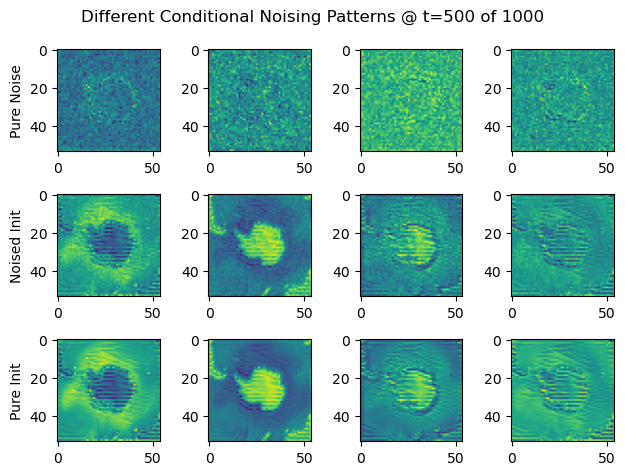

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# demonstrate partial noising of different types
init_image = train_ds[0][0]
init_target = train_ds[0][1]
with torch.autocast(device_type="cuda"):
    z_init = pipeline.vae.encode(init_image.to(torch.half).to("cuda").unsqueeze(0))
    # pad target with zeros across other 8 channels to encode to latent space
    init_target_tensor = torch.cat((init_target.to(torch.half).to("cuda"), torch.zeros((8, 432, 432), device="cuda"))).unsqueeze(0)
    z_target = pipeline.vae.encode(init_target_tensor)
encoded_init = z_init.latent_dist.mode()
encoded_target = z_target.latent_dist.mode()

# start from noise, noised initial condition, and pure initial condition to compare
noise_a = torch.randn_like(encoded_init)
noise_b = torch.randn_like(encoded_init) + encoded_init
noise_c = encoded_init
timesteps = torch.LongTensor([500])
noise_scheduler = pipeline.scheduler
noisy_encoded_a = noise_scheduler.add_noise(encoded_target, noise_a, timesteps)
noisy_encoded_b = noise_scheduler.add_noise(encoded_target, noise_b, timesteps)
noisy_encoded_c = noise_scheduler.add_noise(encoded_target, noise_c, timesteps)

# see noised image
fig, ax = plt.subplots(3, 4)
noisys = [noisy_encoded_a, noisy_encoded_b, noisy_encoded_c]
mats = [t.detach().cpu().squeeze().numpy() for t in noisys]
labels = ["Pure Noise", "Noised Init", "Pure Init"]
for i in range(3):
    for j in range(4):
        ax[i][j].imshow(mats[i][j, :, :])
    ax[i][0].set_ylabel((labels[i]))
plt.suptitle("Different Conditional Noising Patterns @ t=500 of 1000")
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

# demonstrate loss computation on noised image
with torch.autocast(device_type="cuda"):
    encoder_hidden_states = torch.zeros((1, 1, 768))
    noise_pred_a = pipeline.unet(noisy_encoded_a, timesteps, encoder_hidden_states).sample
    noise_pred_b = pipeline.unet(noisy_encoded_b, timesteps, encoder_hidden_states).sample
    noise_pred_c = pipeline.unet(noisy_encoded_c, timesteps, encoder_hidden_states).sample

loss_a = F.mse_loss(noise_pred_a, noise_a)
loss_b = F.mse_loss(noise_pred_b, noise_b)
loss_c = F.mse_loss(noise_pred_c, noise_c)
loss_a, loss_b, loss_c

As one might expect, the model does best predicting noise from images which were noised by pure Gaussian. 
Interestingly, however, the model does better at predicting a pure target than a noised target. Anywho. Let's try to train.

In [7]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer_unet = torch.optim.AdamW(pipeline.unet.parameters(), lr=config.learning_rate)
lr_scheduler_unet = get_cosine_schedule_with_warmup(
    optimizer=optimizer_unet,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dl) * config.num_epochs),
)
pipeline.scheduler.set_timesteps(config.num_train_timesteps)


In [8]:
from tqdm.auto import tqdm
from diffusers.utils import make_image_grid
import os
import matplotlib.pyplot as plt

def evaluate(config, epoch, pipeline, train_dataloader):
    with torch.autocast(device_type="cuda", dtype=torch.half):
        # sample images from batch
        batch = next(iter(train_dataloader))
        x, y, sw = batch

        # create latents and pass latents through unet chain
        latents = pipeline.vae.encode(x.to(torch.half).to("cuda")).latent_dist.mode()
        pipeline.scheduler.set_timesteps(config.num_train_timesteps - 1)
        for t in tqdm(pipeline.scheduler.timesteps):
            # scale latents
            latent_model_input = pipeline.scheduler.scale_model_input(latents, timestep=t)
            # predict the noise residual
            with torch.no_grad():
                noise_pred = pipeline.unet(latent_model_input, t, encoder_hidden_states=torch.zeros((1, 1, 768))).sample
            # compute the previous noisy sample x_t -> x_t-1
            latents = pipeline.scheduler.step(noise_pred, t, latents).prev_sample

        # pass latents through decoder
        outputs = pipeline.vae.decoder(latents)    

    # make plot of outputs
    fig, ax = plt.subplots(2, config.train_batch_size)
    if config.train_batch_size == 1:
        ax[0], ax[1] = [ax[0]], [ax[1]]
    for i in range(config.train_batch_size):
        mat_in = x[i].squeeze().detach().cpu().numpy()
        mat_out = outputs[i].squeeze().detach().cpu().numpy()
        ax[0][i].imshow(mat_in[2])  # just show sea ice layer of input
        ax[0][i].set_title(f"Input {i}")
        ax[1][i].imshow(mat_out)
        ax[1][i].set_title(f"Output {i}")
    plt.tight_layout()

    # save the outputs
    sample_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(sample_dir, exist_ok=True)
    plt.savefig(f"{sample_dir}/{epoch:04d}.png")

  0%|          | 0/51 [00:00<?, ?it/s]

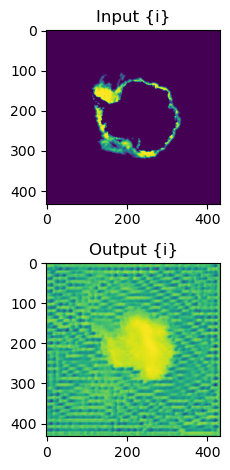

In [9]:
evaluate(config, 0, pipeline, train_dl)

In [11]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import torch.nn.functional as F
import os

def train_loop(config, model, noise_scheduler, optimizer_unet, lr_scheduler_unet, train_dataloader):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="wandb",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers(project_name="icenet-diffusion")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer_unet, lr_scheduler_unet, train_dataloader = accelerator.prepare(
        model, optimizer_unet, lr_scheduler_unet, train_dataloader
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            with torch.autocast(device_type="cuda", dtype=torch.float):
                # unpack batch and create latents
                x, y, sw = batch
                y = torch.cat((y, torch.zeros((config.train_batch_size, 8, 432, 432), device="cuda")), dim=1)
                latents = pipeline.vae.encode(x).latent_dist.mode()
                target_latents = pipeline.vae.encode(y).latent_dist.mode()
                sw_latents = F.interpolate(sw, config.latent_size, mode="nearest")

                # Sample noise to add to the images
                noise = latents
                bs = target_latents.shape[0]

                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bs,), device=target_latents.device,
                    dtype=torch.int64
                )

                # Add noise to the clean images according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_images = noise_scheduler.add_noise(target_latents, noise, timesteps)

                with accelerator.accumulate(model):

                    # Predict the noise residual
                    noise_pred = model(noisy_images, timesteps, encoder_hidden_states=torch.zeros((1, 1, 768))).sample
                    masked_noise_pred = noise_pred * sw_latents

                    loss = F.mse_loss(masked_noise_pred, noise)
                    accelerator.backward(loss)

                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer_unet.step()
                    lr_scheduler_unet.step()
                    optimizer_unet.zero_grad()

                progress_bar.update(1)
                logs = {"loss": loss.detach().item(), "lr": lr_scheduler_unet.get_last_lr()[0], "step": global_step}
                progress_bar.set_postfix(**logs)
                accelerator.log(logs, step=global_step)
                global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline, train_dataloader)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [12]:
from accelerate import notebook_launcher
args = (config, pipeline.unet, pipeline.scheduler, optimizer_unet, lr_scheduler_unet, train_dl)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB. GPU 0 has a total capacty of 14.54 GiB of which 33.62 MiB is free. Including non-PyTorch memory, this process has 14.49 GiB memory in use. Of the allocated memory 14.00 GiB is allocated by PyTorch, and 387.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF